# Importing required libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Multivariate Normal Data

### Sampling The Data


##### helper functions to generate data and distribution


In [2]:
def mn_sample_generator(mean, covar, n_samples):
    L = np.linalg.cholesky(covar)
    Z = np.random.normal(size=(n_samples, covar.shape[0]))
    return Z.dot(L) + mean

def multivariate_normal_distribution(samples, mean, covar, N):
    distribution = []
    for sample in samples:
        sample_m = sample - mean
        covar_det = np.linalg.det(covar)
        covar_inv = np.linalg.inv(covar)
        pdf = (1./np.sqrt((2*np.pi)**N)*covar_det) * np.exp(-0.5*(sample_m).T.dot(covar_inv).dot(sample_m))
        distribution.append(pdf)
    return np.array(distribution)

In [3]:
N = 3
n_samples = 100
X = np.random.normal(size=(N,1))
covar = np.exp(-cdist(X,X, "sqeuclidean")) + 1e-6 + np.eye(X.shape[0])
mean = np.zeros((X.shape[0], ))
samples = mn_sample_generator(mean, covar, n_samples)
samples_df = pd.DataFrame(samples)
distribution = multivariate_normal_distribution(samples, mean, covar, N)

In [4]:
X

array([[-0.06910219],
       [ 0.907035  ],
       [-1.50526813]])

In [5]:
mean, covar

(array([0., 0., 0.]),
 array([[2.000001  , 0.38564377, 0.1271275 ],
        [0.38564377, 2.000001  , 0.00297096],
        [0.1271275 , 0.00297096, 2.000001  ]]))













  ##### sample statistics

In [6]:
samples[:4]

array([[ 1.12875308,  1.73872396,  1.08458926],
       [-1.49411042, -1.06256611,  0.3441762 ],
       [-0.01279669, -0.23639549, -1.7719305 ],
       [-0.87061868, -3.38909156,  0.35001435]])

In [7]:
samples.shape

(100, 3)

In [8]:
np.max(samples, axis=0), np.min(samples, axis=0)

(array([3.89622646, 3.35818857, 3.82197533]),
 array([-3.43656924, -3.49522598, -3.67019302]))

In [9]:
np.mean(samples, axis=0), np.std(samples, axis=0)

(array([-0.04468726, -0.02272069,  0.14580815]),
 array([1.42292507, 1.50227445, 1.46100657]))

##### plots for analysing samples

###### 3D scatter plot

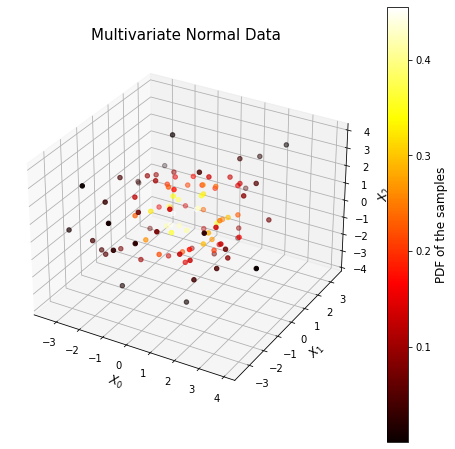

In [10]:
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.set_title('Multivariate Normal Data', fontsize=15)
zAx = samples_df[2]
yAx = samples_df[1]
xAx = samples_df[0]
val = distribution
ax1.set_xlabel('$X_0$', fontsize=12)
ax1.set_ylabel('$X_1$', fontsize=12)
ax1.set_zlabel('$X_2$', fontsize=12)
img = ax1.scatter(xAx, yAx, zAx, c=val, cmap=plt.hot())
cbar = fig1.colorbar(img)
cbar.set_label('PDF of the samples', fontsize=12)
plt.show()

###### distribution plot of variables

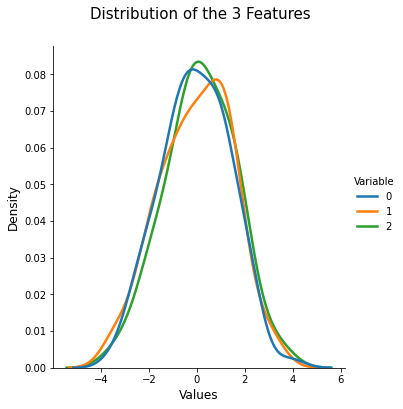

In [11]:
fig2 = sns.displot(data=samples_df, kind='kde', linewidth=2.5, height=5)
fig2.set_axis_labels("Values", "Density", fontsize=12)
fig2.fig.suptitle("Distribution of the 3 Features", fontsize=15, y=1.08)
fig2._legend.set_title('Variable')
plt.show()

###### correlation matrix (heatmap)

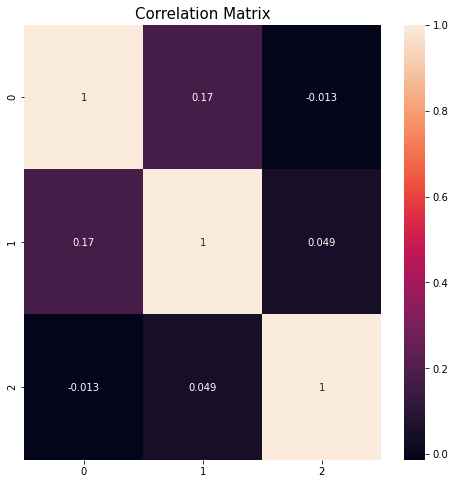

In [12]:
plt.figure(figsize = (8,8))
corr = samples_df.corr()
fig3 = sns.heatmap(corr, annot=True)
fig3.set_title('Correlation Matrix', fontsize=15)
plt.show()

### Univariate Marginal Test Using Q-Q Plot


##### generate Q-Q plot for each variable

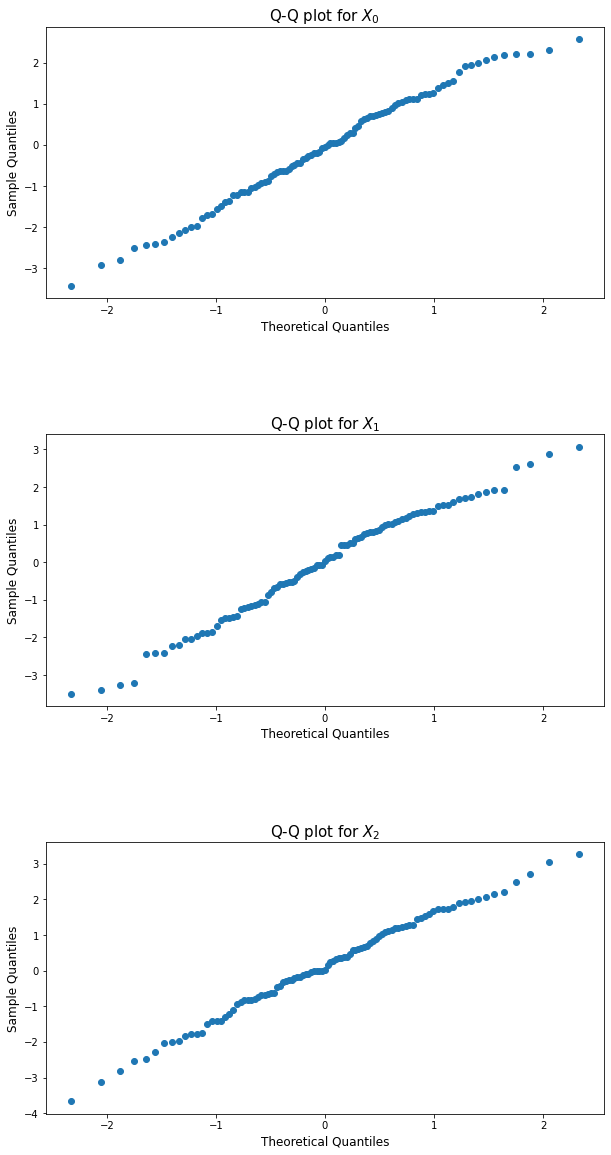

In [13]:
def gen_normal_quantiles():
    norm_quantiles = norm.ppf([(i+1)/n_samples for i in range(n_samples)])
    return norm_quantiles

norm_quantiles = gen_normal_quantiles()
fig4, ax4 = plt.subplots(3,1, figsize=(10,20))
for i in range(N):
    ax4[i].scatter(norm_quantiles, np.sort(samples[:,i]))
    ax4[i].set_title("Q-Q plot for $X_{}$".format(i), fontsize=15)
    ax4[i].set_xlabel("Theoretical Quantiles".format(i), fontsize=12)
    ax4[i].set_ylabel("Sample Quantiles".format(i), fontsize=12)
fig4.subplots_adjust(hspace=.5)
plt.show()

### Helper functions for bivariate and multivariate normality

In [14]:
def mahalanobis_squared_distance(sub):
    distances = np.zeros(n_samples)
    m = np.mean(sub, axis=0)
    c = np.cov(sub.T)
    for i in range(n_samples): 
        sample_m = sub[i] - m
        covar_inv = np.linalg.inv(c)
        dist = (sample_m).T.dot(covar_inv).dot(sample_m)
        distances[i] = dist
    return np.sort(distances)

def chiSq_quantiles():
    quantiles = chi2.ppf([(i-0.5)/n_samples for i in range(1,n_samples+1)], N)
    return quantiles

pairs = [(i,j) for i in range(N-1) for j in range(i+1, N)]
chi_quantiles = chiSq_quantiles()

### Bivariate and Multivariate Normality


##### scattered pairplot for all variables

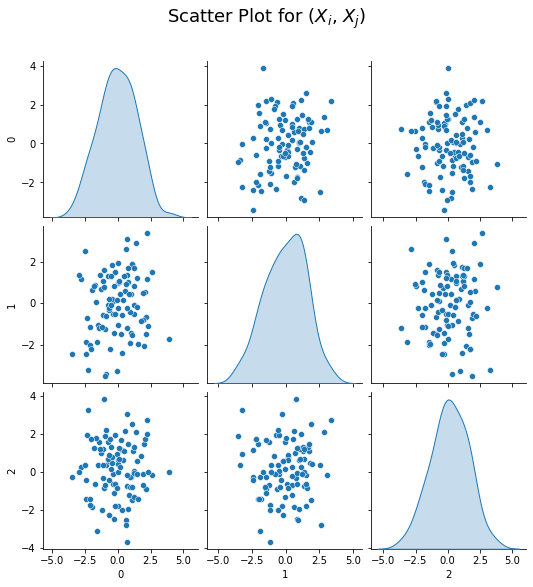

In [15]:
fig5 = sns.pairplot(samples_df, diag_kind='kde')
fig5.fig.suptitle("Scatter Plot for ($X_i$, $X_j$)", fontsize=18, y=1.08)
plt.show()

###### Bivariate Chi-Square Q-Q Plot

##### contour plots for each pair of variables

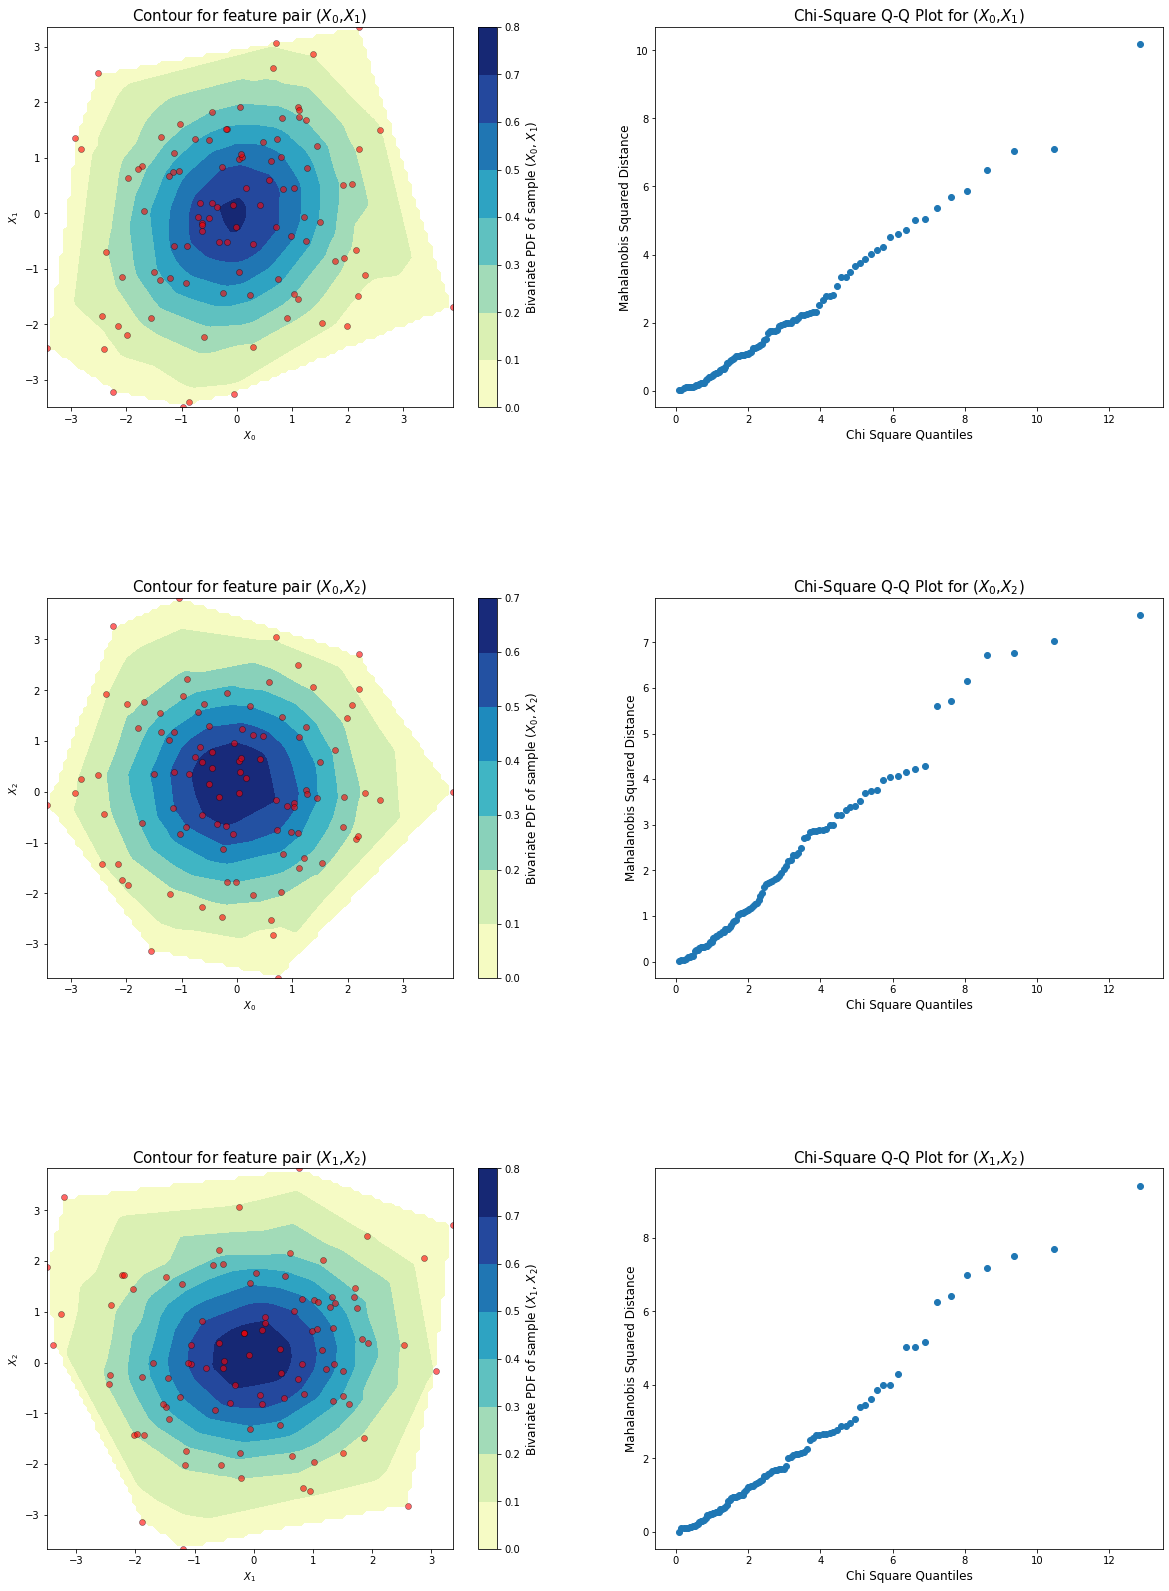

In [16]:
fig6, ax6 = plt.subplots(len(pairs),2, figsize=(20,28))
fig6.subplots_adjust(hspace=.5)
for i in range(len(pairs)):
    """
    contour plots in first column
    """ 
    x6, y6 = samples[:, pairs[i][0]], samples[:, pairs[i][1]]
    submatrix = samples_df[[pairs[i][0],pairs[i][1]]].values
    z6 = multivariate_normal_distribution(submatrix, np.mean(submatrix, axis=0), np.cov(submatrix.T), N=2) 
    x6grid = np.linspace(x6.min(), x6.max(), n_samples)
    y6grid = np.linspace(y6.min(), y6.max(), n_samples)
    x6grid, y6grid = np.meshgrid(x6grid, y6grid)
    z6grid = griddata((x6,y6),z6, (x6grid, y6grid))
    img = ax6[i][0].contourf(x6grid, y6grid, z6grid, cmap=cm.YlGnBu)
    ax6[i][0].set_title('Contour for feature pair ($X_{}$,$X_{}$)'.format(pairs[i][0],pairs[i][1]), fontsize=15)
    ax6[i][0].set_xlabel("$X_{}$".format(pairs[i][0]))
    ax6[i][0].set_ylabel("$X_{}$".format(pairs[i][1]))
    ax6[i][0].plot(samples[:,pairs[i][0]], samples[:, pairs[i][1]], 'ro', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)
    cbar = plt.colorbar(img, ax=ax6[i][0])
    cbar.set_label('Bivariate PDF of sample ($X_{}$, $X_{}$)'.format(pairs[i][0], pairs[i][1]), fontsize=12)

    """
    chi-sq q-q plots in second column
    """ 
    manhalanobis_distances_bi = mahalanobis_squared_distance(submatrix)
    ax6[i][1].scatter(chi_quantiles, manhalanobis_distances_bi)
    ax6[i][1].set_title('Chi-Square Q-Q Plot for ($X_{}$,$X_{}$)'.format(pairs[i][0],pairs[i][1]), fontsize=15)
    ax6[i][1].set_xlabel('Chi Square Quantiles', fontsize=12)
    ax6[i][1].set_ylabel('Mahalanobis Squared Distance', fontsize=12)

### Multivariate Normality

##### generate Chi-Square Q-Q Plot

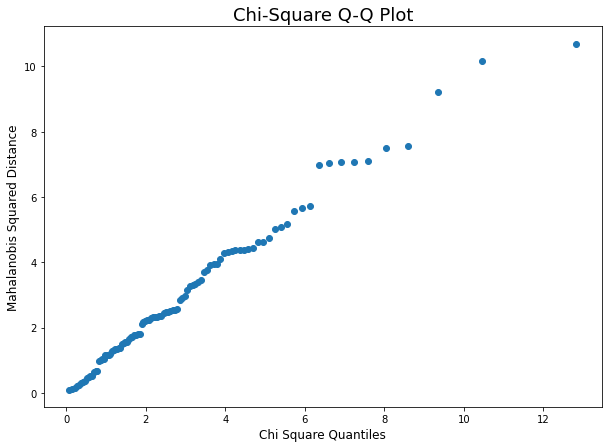

In [17]:
mahalanobis_distances_tri1 = mahalanobis_squared_distance(samples)
fig7 = plt.figure(figsize=(10,7))
plt.scatter(chi_quantiles, mahalanobis_distances_tri1)
plt.title('Chi-Square Q-Q Plot', fontsize=18)
plt.xlabel('Chi Square Quantiles', fontsize=12)
plt.ylabel('Mahalanobis Squared Distance', fontsize=12)
plt.show()

###### normality of linear combination

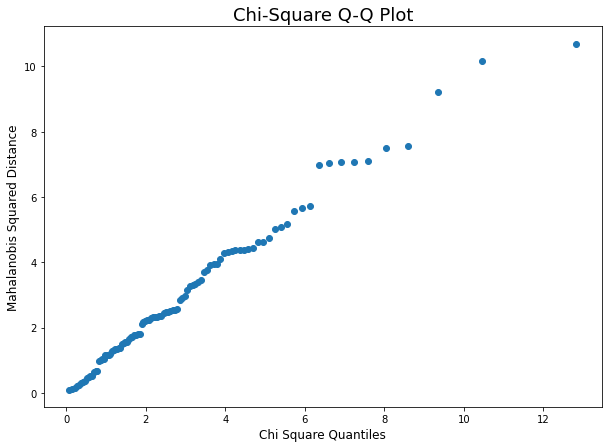

In [18]:
a = 1
b = 2
c = -3
samples[:,0] *= a
samples[:,1] *= b + 2
samples[:,2] *= c + 5
mahalanobis_distances_tri2 = mahalanobis_squared_distance(samples)
fig8 = plt.figure(figsize=(10,7))
plt.scatter(chi_quantiles, mahalanobis_distances_tri2)
plt.title('Chi-Square Q-Q Plot', fontsize=18)
plt.xlabel('Chi Square Quantiles', fontsize=12)
plt.ylabel('Mahalanobis Squared Distance', fontsize=12)
plt.show()